In [1]:
import sys, os, glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import warnings
from scipy.stats import percentileofscore

# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

%matplotlib inline
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'
# plt.rcParams['pdf.fonttype'] = 42

# make a folder to store figures if not already there
!mkdir ../jupyter_figures


mkdir: ../jupyter_figures: File exists


In [2]:
def plot_cum_dist(data, n_bins=None, output_fig_path=None, x_ticks=None, y_ticks=None, y_log_scale=False, fig_width=1.0, fig_height=1.0):
    '''Plot a black curve and a blue histogram representing cumulative distribution of data
    '''
    
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
    ax = sns.kdeplot(data, cumulative=True, linewidth=0.8, legend=False, color='k')
    
    plt.hist(data, bins=n_bins, cumulative=True, density=True, color='Blue', rwidth=.9, alpha=.6)
#     ax = sns.distplot(data, kde=False, hist_kws={'cumulative': True, 'rwidth': .9, 'alpha': .5}, norm_hist=True, color='Blue')

    plt.ylabel("Cumulative\nfraction of data")
    
    if x_ticks is not None:
        plt.xticks(x_ticks)

    if y_ticks is not None:
        plt.yticks(y_ticks)
        
    if y_log_scale == True:
    # seems to have issues, may address in the future
        ax.set(yscale="log")
    
    # The following removes excessive clipping to facilitate detailing of line widths and colors etc in illustrator
    for o in fig.findobj():
        o.set_clip_on(False)
    for o in ax.findobj():
        o.set_clip_on(False)
    
    if output_fig_path is not None:
        plt.savefig(output_fig_path)
    
    return ax

def plot_dist(data, n_bins=None, output_fig_path=None, x_ticks=None, y_ticks=None, y_log_scale=False, fig_width=1.0, fig_height=1.0):
    '''Plot a black curve and a blue histogram representing cumulative distribution of data
    '''
    
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
    ax = sns.kdeplot(data, cumulative=False, linewidth=0.8, legend=False, color='k')
    
    plt.hist(data, bins=n_bins, cumulative=False, density=True, color='Blue', rwidth=.9, alpha=.6)
#     ax = sns.distplot(data)

    plt.ylabel("Probablity density")
    
    if x_ticks is not None:
        plt.xticks(x_ticks)

    if y_ticks is not None:
        plt.yticks(y_ticks)
        
    if y_log_scale == True:
    # seems to have issues, may address in the future
        ax.set(yscale="log")
    
    # The following removes excessive clipping to facilitate detailing of line widths and colors etc in illustrator
    for o in fig.findobj():
        o.set_clip_on(False)
    for o in ax.findobj():
        o.set_clip_on(False)
    
    if output_fig_path is not None:
        plt.savefig(output_fig_path)
    
    return ax


In [3]:
# Read in the TrackMate exported long-term manual tracking data of cell divisions for plotting
f = '../data/cell-division-tracking-data/180218-mTmGHisG-ROI1-track-info-with-cell-division-id.csv'
df = pd.read_csv(f)
# df.head()

df.sort_values(by=['cell_division_id', 'track_id', 't'], inplace=True)
df.reset_index(inplace=True, drop=True)

# Drop the daughter cells whose tracks were incomplete (goes beyond the FOV or time series)
cell_division_id_to_drop = ['incomplete1A', 'incomplete1B']
df = df[~df.cell_division_id.isin(cell_division_id_to_drop)]

# Remove the A, B postfix to consolidate cell_division id
df.cell_division_id = [i[:-1] for i in df.cell_division_id]

print(df.shape)
df.tail()


(4192, 7)


,cell_division_id,track_id,spot_id,x,y,z,t
4187,9,44,13110,145.390020,124.413351,14.0,59
4188,9,44,13116,144.873354,125.550018,14.0,60
4189,9,44,13122,145.286687,125.756684,14.0,61
4190,9,44,13128,145.183354,124.723351,14.0,62
4191,9,44,13131,146.216687,125.343351,12.0,63


In [4]:
df.cell_division_id.nunique()


42

In [5]:
# In manual tracking using Trackmate, one of the daughter cells begin from the separation of 
# the two daughter cells (anaphase onset).
#
# To plot the tracks that reflect the overlapping origin of both daughter cells, append
# the surface to anaphase onset part of tracks from the matching daughter cell

for cell_division in df.cell_division_id.unique():
# for cell_division in [20]:# for testing
    df_temp = df[df.cell_division_id==str(cell_division)]
#     print(df_temp.shape)
    assert df_temp.track_id.nunique() == 2
    track1 = df_temp[df_temp.track_id==df_temp.track_id.unique()[0]]
    track2 = df_temp[df_temp.track_id==df_temp.track_id.unique()[1]]
    if track1.t.min() < track2.t.min():
        to_add = track1[track1.t < track2.t.min()]
        assert to_add.shape[0] > 0
        to_add.loc[:,'track_id'] = [ df_temp.track_id.unique()[1] ] * to_add.shape[0]
    else:
        to_add = track2[track2.t < track1.t.min()]
        assert to_add.shape[0] > 0
        to_add.loc[:,'track_id'] = [ df_temp.track_id.unique()[0] ] * to_add.shape[0]
    df = pd.concat([df, to_add])
    df.reset_index(inplace=True, drop=True)

df.sort_values(by=['cell_division_id', 'track_id', 't'], inplace=True)
df.reset_index(inplace=True, drop=True)
print(df.shape)


(4697, 7)


/Users/wangs20/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


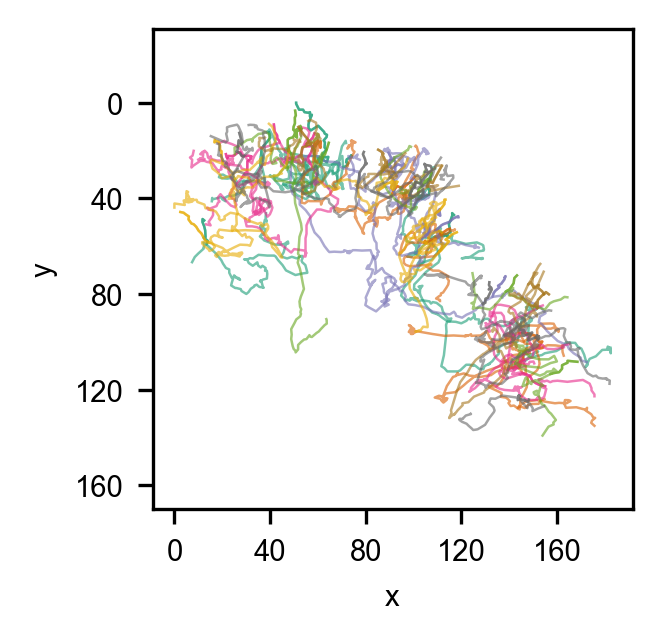

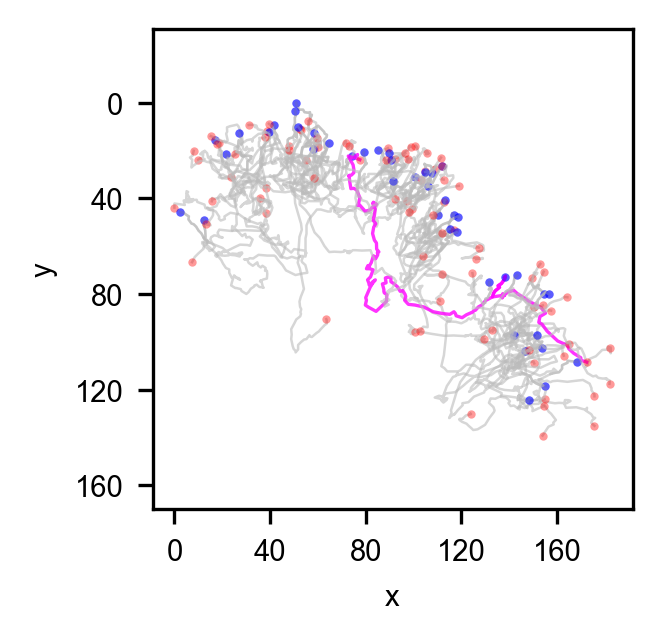

In [6]:
def plot_tracks_2D(trackDF, output_fig_path=None,
                   plot_style='white', line_color=None,
                   track_list=None, tracks_highlight=None,
                   x_ticks=None, y_ticks=None,
                   draw_spot_start=False, draw_spot_end=False):

    from matplotlib import cm
    # Create a colors dictionary to set same color for the daughter cells of the same cell division
    colors = cm.Dark2(np.linspace(0, 1, trackDF.cell_division_id.nunique()))
    colors = [val for pair in zip(colors, colors) for val in pair]

    fig = plt.figure(figsize=(2, 2), dpi=300)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    x_min, y_min = trackDF.x.min(), trackDF.y.min()
    if track_list is None:
        track_list = trackDF.track_id.unique()
    for i, track in enumerate(track_list):
        df_temp = df[df.track_id==track]
        x, y = df_temp.x.values-x_min, df_temp.y.values-y_min
        
        if (tracks_highlight is not None) and (track in tracks_highlight):
            ax.plot(x, y, '-', color='#FF00FF', alpha=.8, lw=.8)
        else:
#             ax.plot(x, y, '-', color=line_color, alpha=.6, lw=.6)
            if line_color is None:
                ax.plot(x, y, '-', color=colors[i], alpha=.6, lw=.6)
            else:
                ax.plot(x, y, '-', color=line_color, alpha=.6, lw=.6)

        if draw_spot_start == True:
            ax.plot(x[0], y[0], 'ob', alpha=.4, markersize=2, markeredgewidth=0)
        if draw_spot_end == True:
            ax.plot(x[-1], y[-1], 'or', alpha=.4, markersize=2, markeredgewidth=0)
    
    # *** add axis labels ***
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # *** set axis ticks if provided ***
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
    if y_ticks is not None:
        ax.set_yticks(y_ticks)
    
    # *** Make the x and y axes equal in dimension to mimic image display ***
    ax.axis('equal')
    
    # *** Flip the y-axis to match the image coordinates ***
    plt.gca().invert_yaxis()
    
    for o in fig.findobj():
        o.set_clip_on(False)
    for o in ax.findobj():
        o.set_clip_on(False)
    
    if output_fig_path is not None:
        plt.savefig(output_fig_path)
    
    return ax

output_filename = '../jupyter_figures/' + '180218-mTmGHisG-ROI1-TrackMate-exported-tracks-2D-all-tracks.svg'
plot_tracks_2D(df, output_fig_path=output_filename,
              x_ticks=np.arange(0, 201, 40), y_ticks=np.arange(0, 201, 40))

output_filename = '../jupyter_figures/' + '180218-mTmGHisG-ROI1-TrackMate-exported-tracks-2D-highlight-tracks.svg'
plot_tracks_2D(df, output_fig_path=output_filename, tracks_highlight=[110, 121],
               x_ticks=np.arange(0, 201, 40), y_ticks=np.arange(0, 201, 40), 
               line_color='#BBBBBB', draw_spot_start=True, draw_spot_end=True)


x, y, z min:  16.5850023219 26.5566703846 12.0
x, y, z max:  199.020027863 165.695023197 88.0
x, y, z min:  16.5850023219 26.5566703846 12.0
x, y, z max:  199.020027863 165.695023197 88.0


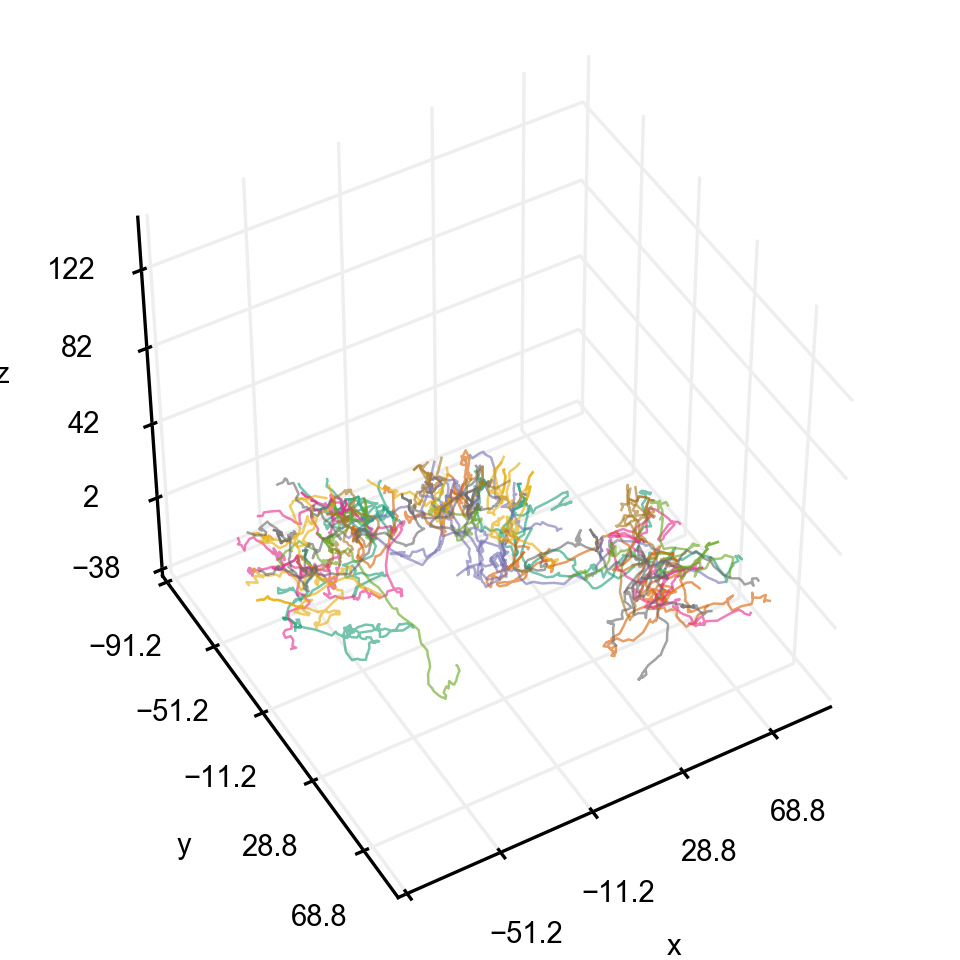

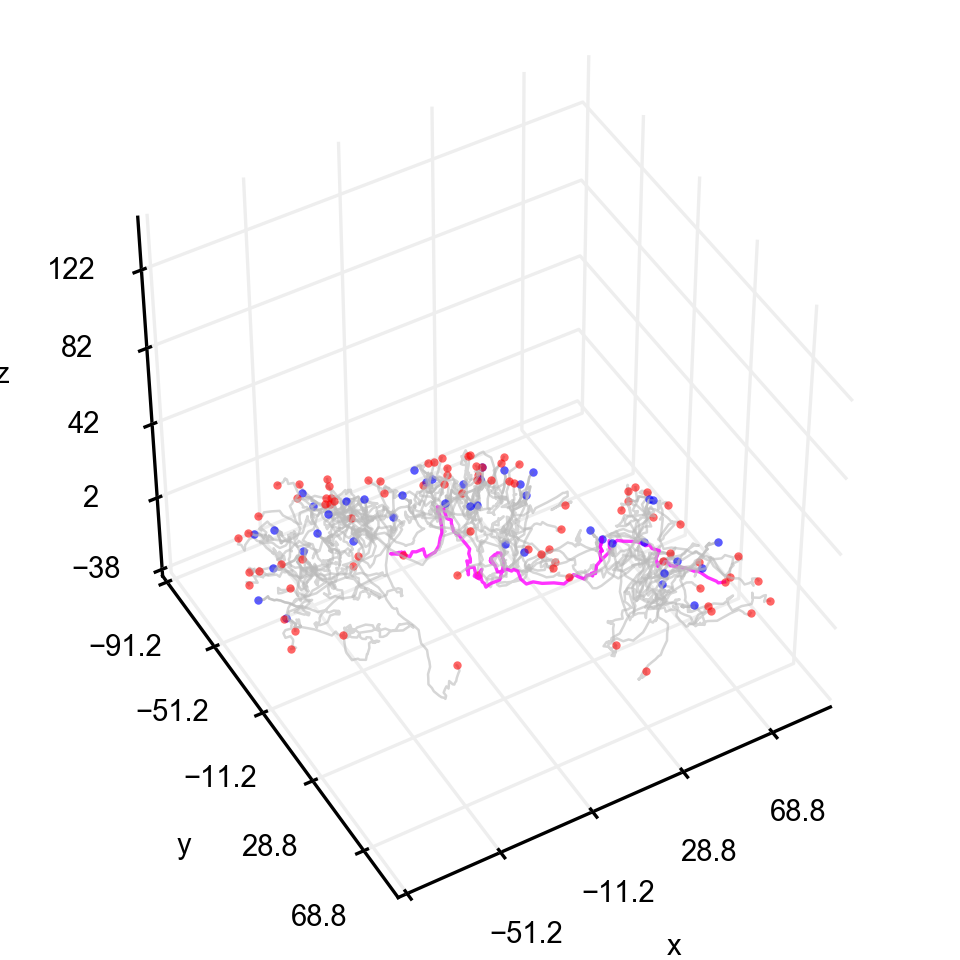

In [7]:
def plot_tracks_3D(trackDF, output_fig_path=None,
                   plot_style='white', line_color=None,
                   track_list=None, tracks_highlight=None,
                   centering=True, draw_spot_start=False, draw_spot_end=False):
    """This script takes the spot position data of all tracks in 3D
    """
#     VOXEL_DEPTH = 2.0 # in micron
#     TIME_INTERVAL = 5.0 # in minutes
    W, H, DPI = 3, 3, 300 # fig size in inches -- make sure W = H since scaling was customized below

    import matplotlib as mpl
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    # Create a colors dictionary to set same color for the daughter cells of the same cell division
#     colors = cm.jet(np.linspace(0, 1, df.cell_division_id.nunique()))
#     colors = cm.Set1(np.linspace(0, 1, df.cell_division_id.nunique()))
    colors = cm.Dark2(np.linspace(0, 1, trackDF.cell_division_id.nunique()))
    colors = [val for pair in zip(colors, colors) for val in pair]
    
    if plot_style=='white':
        AXES_COLOR = '#000000'#black
        mpl.rc('figure', facecolor='w', edgecolor=AXES_COLOR)
        mpl.rc('axes', facecolor='w', edgecolor=AXES_COLOR, labelcolor=AXES_COLOR)
        mpl.rc('xtick', color=AXES_COLOR)
        mpl.rc('ytick', color=AXES_COLOR)
        mpl.rc('grid', color='#EEEEEE')
    
    if plot_style=='dark':
        AXES_COLOR = '#FFFFFF'#white
        mpl.rc('figure', facecolor='k', edgecolor=AXES_COLOR)
        mpl.rc('axes', facecolor='k', edgecolor=AXES_COLOR, labelcolor=AXES_COLOR)
        mpl.rc('xtick', color=AXES_COLOR)
        mpl.rc('ytick', color=AXES_COLOR)
        mpl.rc('grid', color='gray')
    
    # plotting set up
    fig = plt.figure(figsize=(W, H), dpi=DPI)
    ax = fig.add_axes([0, 0, 1.0, 1.0], projection='3d')
    
    if plot_style=='white':
        # *** Set the background color of the panes ***
        PANECOLOR = (1, 1, 1, 1.0) # white
        ax.w_xaxis.set_pane_color(PANECOLOR)
        ax.w_yaxis.set_pane_color(PANECOLOR)
        ax.w_zaxis.set_pane_color(PANECOLOR)
        # *** Set the line colors of x,y,z axes ***
        AXISCOLOR = (0, 0, 0, 1.0) # black
        ax.w_xaxis.line.set_color(AXISCOLOR)
        ax.w_yaxis.line.set_color(AXISCOLOR)
        ax.w_zaxis.line.set_color(AXISCOLOR)

    if plot_style=='dark':
        # *** Set the background color of the panes ***
        # PANECOLOR = (0.1, 0.1, 0.1, 1.0) # dark grey
        PANECOLOR = (0, 0, 0, 1.0) # black
        ax.w_xaxis.set_pane_color(PANECOLOR)
        ax.w_yaxis.set_pane_color(PANECOLOR)
        ax.w_zaxis.set_pane_color(PANECOLOR)
        # *** Set the line colors of x,y,z axes ***
        AXISCOLOR = (1.0, 1.0, 1.0, 1.0) # white
        ax.w_xaxis.line.set_color(AXISCOLOR)
        ax.w_yaxis.line.set_color(AXISCOLOR)
        ax.w_zaxis.line.set_color(AXISCOLOR)
    
    # calculate the range values and scales in each dimension
    tMin, tMax = trackDF.t.min(), trackDF.t.max()
    xMin, xMax = trackDF.x.min(), trackDF.x.max()
    yMin, yMax = trackDF.y.min(), trackDF.y.max()
    zMin, zMax = trackDF.z.min(), trackDF.z.max()
    print('x, y, z min: ', xMin, yMin, zMin)
    print('x, y, z max: ', xMax, yMax, zMax)
    if centering == False:
        shift_x, shift_y, shift_z = 0, 0, 0
    else:
        shift_x, shift_y, shift_z = np.mean([xMax, xMin]), np.mean([yMax, yMin]), np.mean([zMax, zMin])

    if track_list is None:
        track_list = trackDF.track_id.unique()
    for i, track in enumerate(track_list):
        temp = trackDF.loc[trackDF.track_id == track]
        temp = temp.sort_values('t', ascending=True)
        x, y, z = temp.x, temp.y, temp.z
        x, y, z = np.array(x), np.array(y), np.array(z)
        if (tracks_highlight is not None) and (track in tracks_highlight):
            ax.plot(x-shift_x, y-shift_y, z-shift_z, '-', color='#FF00FF', alpha=.8, lw=.8)
        else:
            if line_color is None:
                ax.plot(x-shift_x, y-shift_y, z-shift_z, '-', color=colors[i], alpha=.6, lw=.6)
            else:
                ax.plot(x-shift_x, y-shift_y, z-shift_z, '-', color=line_color, alpha=.6, lw=.6)

        if draw_spot_start == True:
            ax.plot([x[0]-shift_x], [y[0]-shift_y], [z[0]-shift_z], 'ob', alpha=.4, markersize=2, markeredgewidth=0)
        if draw_spot_end == True:
            ax.plot([x[-1]-shift_x], [y[-1]-shift_y], [z[-1]-shift_z], 'or', alpha=.6, markersize=2, markeredgewidth=0)

    # *** adjust axis limits and turn on/off grids -- has to be after plotting ***
    x0, y0, z0 = xMin-shift_x, yMin-shift_y, zMin-shift_z
    if abs(x0) > abs(y0):
        y0 = x0
    else:
        x0 = y0
#     x0, y0, z0 = -100, -100, -40
#     x0, y0, z0 = -95, -95, -40
#     x0, y0, z0 = -120, -120, -40
    axisLength = abs(x0) * 2
    ax.set_xlim( x0, x0 + axisLength )
    ax.set_ylim( y0, y0 + axisLength )
    ax.set_zlim( z0, z0 + axisLength )
    
    # *** customize grid size ***
    grid_size = 40
    ax.set_xticks(np.arange( x0, x0 + axisLength + 1, grid_size))
    ax.set_yticks(np.arange( y0, y0 + axisLength + 1, grid_size))
    ax.set_zticks(np.arange( z0, z0 + axisLength + 1, grid_size))

    # *** add axis labels ***
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

#     ax.grid(False)
    ax.view_init(45, 60) # elevation and azimuth angles for viewpoint settting

    # Flip the y-axis to match the image coordinates
    plt.gca().invert_yaxis()
    
    for o in fig.findobj():
        o.set_clip_on(False)
    for o in ax.findobj():
        o.set_clip_on(False)
    
    if output_fig_path is not None:
        plt.savefig(output_fig_path)
    
    return ax

output_filename = '../jupyter_figures/' + '180218-mTmGHisG-ROI1-TrackMate-exported-tracks-3D-color-by-tracks.svg'
plot_tracks_3D(df, output_fig_path=output_filename,
#                centering=False,
#                line_color='k',
               draw_spot_start=False, draw_spot_end=False)

# output_filename = './jupyter_figures/' + '180218-mTmGHisG-ROI1-TrackMate-exported-tracks-3D-color-black-add-dots.svg'
# plot_tracks_3D(df, output_fig_path=output_filename,
#                line_color='k', draw_spot_start=True, draw_spot_end=True)

output_filename = '../jupyter_figures/' + '180218-mTmGHisG-ROI1-TrackMate-exported-tracks-3D-selected-tracks-highlight.svg'
plot_tracks_3D(df, output_fig_path=output_filename, tracks_highlight=[110, 121],
               line_color='#BBBBBB', draw_spot_start=True, draw_spot_end=True)


In [8]:
# Play with color maps of the matplotlib
from matplotlib import cm
colors = cm.jet(np.linspace(0, 1, df.cell_division_id.nunique()))
cell_division_id = df.cell_division_id.unique()
colorsDict = dict( [ (cell_division_id[i], colors[i]) for i in range(len(colors)) ] )
colorsDict['9']
# colors = iter(cm.rainbow(np.linspace(0, 1, len(meanGFPlist))))


array([0.5, 0. , 0. , 1. ])

In [9]:
# Read in the categorical data of cell division outcome scoring
# Each file is from one data set with a track_id column and an interior_number column,
# which use number "1", "2" or "0" to indicate all three possible cell division outcomes

df1 = pd.read_csv('../data/cell-division-tracking-data/180218-mTmGHisG-2photon-cell-division-outcome.csv')
df1.track_id = ['180218_' + str(track_id) for track_id in df1.track_id]
df2 = pd.read_csv('../data/cell-division-tracking-data/190227-mTmGHisG-2_E13-1_denoised-BCratio-cell-division-outcome.csv')
df2.track_id = ['190227_' + str(track_id) for track_id in df2.track_id]
df3 = pd.read_csv('../data/cell-division-tracking-data/190331-4_K14Rhet-HisG-1-1-denoised-BCratio-stacked-t1-120-cell-division-outcome.csv')
df3.track_id = ['190331_' + str(track_id) for track_id in df3.track_id]

df = pd.concat([df1, df2, df3])
df.head()

df.groupby('number_interior').describe()
# df.shape


track_id                       
                   count unique        top freq
number_interior                                
1                     22     22  190227_18    1
2                    267    267  190227_92    1

case 1 ratio: 0.9238754325259516
case 2 ratio: 0.07612456747404844


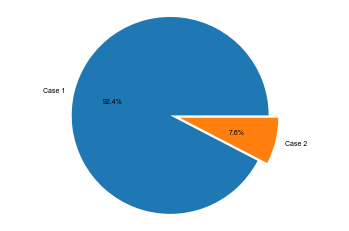

In [10]:
# Make pie chart to represent the proportion of the two cases (types)
case1_proportion = 267 / 289
case2_proportion = 22 / 289
print('case 1 ratio:', case1_proportion)
print('case 2 ratio:', case2_proportion)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Case 1', 'Case 2'
sizes = [case1_proportion, case2_proportion]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Case 2')

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=0)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# The following removes excessive clipping to facilitate detailing of line widths and colors etc in illustrator
for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

plt.savefig('../jupyter_figures/cell-division-outcome-pie-chart.svg')


In [11]:
f = '../data/cell-division-tracking-data/180218-mTmGHisG-2photon-cell-division-returning-time.csv'
df = pd.read_csv(f, header = 0, sep=',')
df.head()
print('total number of data points:', len(df))


total number of data points: 84


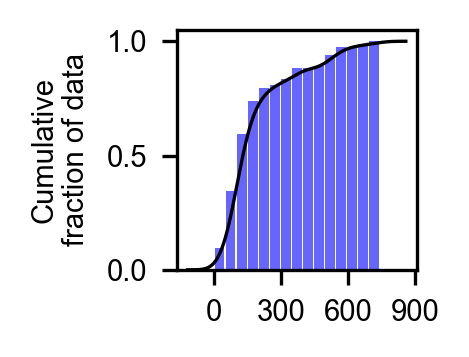

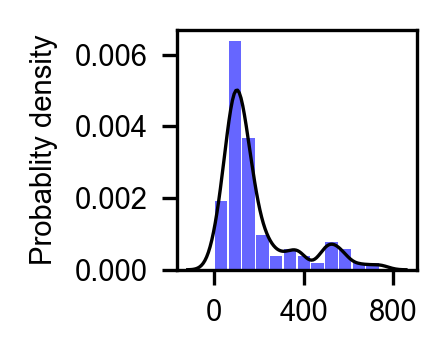

In [12]:
dataset_prefix = '180218-mTmGHisG-2photon-cell-division-returning-time'
output_fig_path = '../jupyter_figures/' + dataset_prefix + '-CDF.svg'
plot_cum_dist(df.anaphase_to_surface_return, n_bins=15, output_fig_path=output_fig_path, x_ticks=[0,300,600,900])

output_fig_path = '../jupyter_figures/' + dataset_prefix + '-distribution.svg'
plot_dist(df.anaphase_to_surface_return, n_bins=12, output_fig_path=output_fig_path, x_ticks=[0,400,800])


In [13]:
# Identify the percentile of 240 min (4 hours)
per_240 = percentileofscore(df.anaphase_to_surface_return, 240)
print('The percentile of 240 min is:', per_240)


The percentile of 240 min is: 79.76190476190476
